In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "fruits",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 12335 files belonging to 16 classes.


In [4]:
class_names = dataset.class_names
class_names

['FreshApple',
 'FreshBanana',
 'FreshGrape',
 'FreshGuava',
 'FreshJujube',
 'FreshOrange',
 'FreshPomegranate',
 'FreshStrawberry',
 'RottenApple',
 'RottenBanana',
 'RottenGrape',
 'RottenGuava',
 'RottenJujube',
 'RottenOrange',
 'RottenPomegranate',
 'RottenStrawberry']

In [5]:
len(dataset)

386

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[ 5  6  0  2  4  9  4  6  2  9  0  7 12 10 10 12 10  7  4  3 14 13  9  0
  7 10  8  8  2  3 10  8]


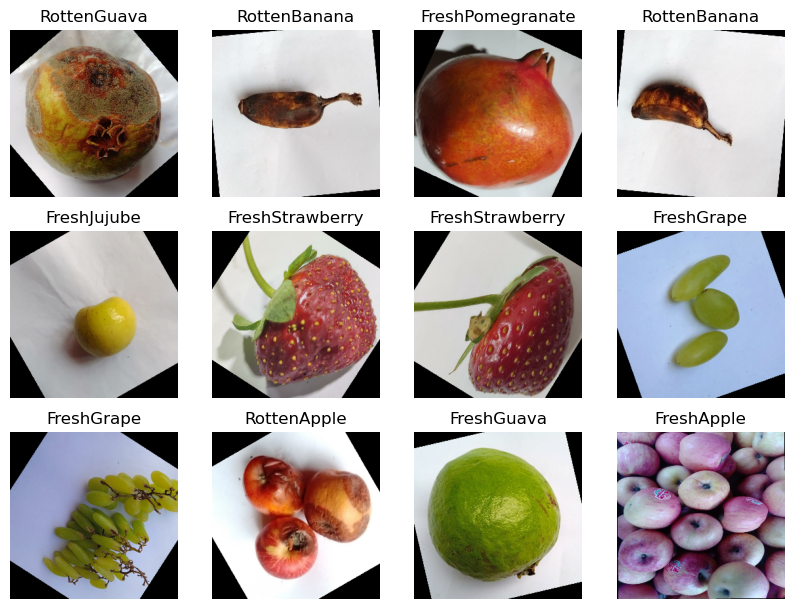

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
len(dataset)

386

In [9]:
train_size = 0.8
len(dataset)*train_size


308.8

In [10]:
train_ds = dataset.take(308)
len(train_ds)

308

In [11]:
test_ds = dataset.skip(308)
len(test_ds)

78

In [12]:
val_size=0.1
len(dataset)*val_size

38.6

In [13]:
val_ds = test_ds.take(38)
len(val_ds)

38

In [14]:
test_ds = test_ds.skip(308)
len(test_ds)

0

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

308

In [18]:
len(val_ds)

38

In [19]:
len(test_ds)

40

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [24]:

input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 16

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [25]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [26]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [27]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50


2023-10-08 19:52:13.700160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 111 of 10000
2023-10-08 19:52:33.660634: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 339 of 10000
2023-10-08 19:52:37.521949: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-10-08 19:52:37.678637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


308/308 [==============================] - ETA: 0s - loss: 1.9665 - accuracy: 0.3290

2023-10-08 20:00:08.736443: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 83 of 10000
2023-10-08 20:00:28.763000: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 277 of 10000
2023-10-08 20:00:38.753743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.
2023-10-08 20:00:39.326301: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:25: Filling up shuffle buffer (this may take a while): 1 of 1000
2023-10-08 20:00:39.403734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


308/308 [==============================] - 531s 2s/step - loss: 1.9665 - accuracy: 0.3290 - val_loss: 1.0890 - val_accuracy: 0.6308
Epoch 2/50
308/308 [==============================] - 405s 1s/step - loss: 0.9298 - accuracy: 0.6710 - val_loss: 0.7350 - val_accuracy: 0.7352
Epoch 3/50
308/308 [==============================] - 399s 1s/step - loss: 0.7043 - accuracy: 0.7421 - val_loss: 0.5771 - val_accuracy: 0.7928
Epoch 4/50
308/308 [==============================] - 403s 1s/step - loss: 0.5466 - accuracy: 0.8055 - val_loss: 0.5008 - val_accuracy: 0.8084
Epoch 5/50
308/308 [==============================] - 409s 1s/step - loss: 0.4740 - accuracy: 0.8277 - val_loss: 0.3674 - val_accuracy: 0.8684
Epoch 6/50
308/308 [==============================] - 407s 1s/step - loss: 0.4286 - accuracy: 0.8435 - val_loss: 0.3993 - val_accuracy: 0.8479
Epoch 7/50
308/308 [==============================] - 396s 1s/step - loss: 0.3640 - accuracy: 0.8682 - val_loss: 0.3966 - val_accuracy: 0.8561
Epoch 8/50

In [28]:
scores = model.evaluate(test_ds)

2023-10-09 01:14:00.671987: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:422] ShuffleDatasetV3:15: Filling up shuffle buffer (this may take a while): 235 of 10000
2023-10-09 01:14:06.744703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


 1/40 [..............................] - ETA: 10:51 - loss: 0.0887 - accuracy: 0.9688

2023-10-09 01:14:07.159169: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] Shuffle buffer filled.


40/40 [==============================] - 24s 175ms/step - loss: 0.0738 - accuracy: 0.9789


In [29]:
scores


[0.07384193688631058, 0.9789062738418579]

In [30]:
history

In [31]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 308}

In [32]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [33]:
type(history.history['loss'])

list

In [34]:
len(history.history['loss'])

50

In [35]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.9665348529815674,
 0.9297711849212646,
 0.704250693321228,
 0.5466328263282776,
 0.4739975333213806]

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

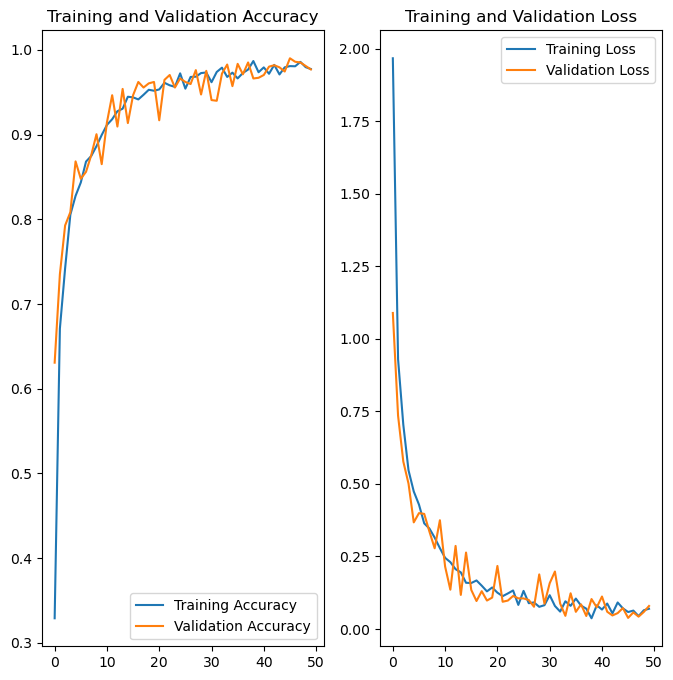

In [37]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: RottenApple
1/1 [==============================] - 0s 267ms/step
predicted label: RottenApple


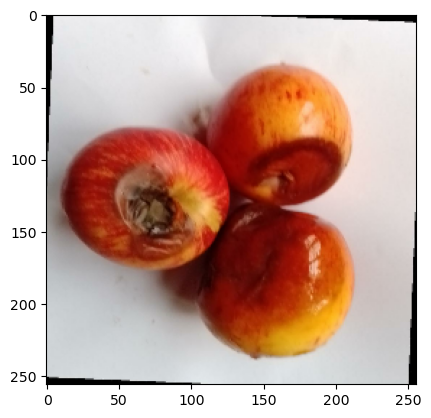

In [39]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 14ms/step


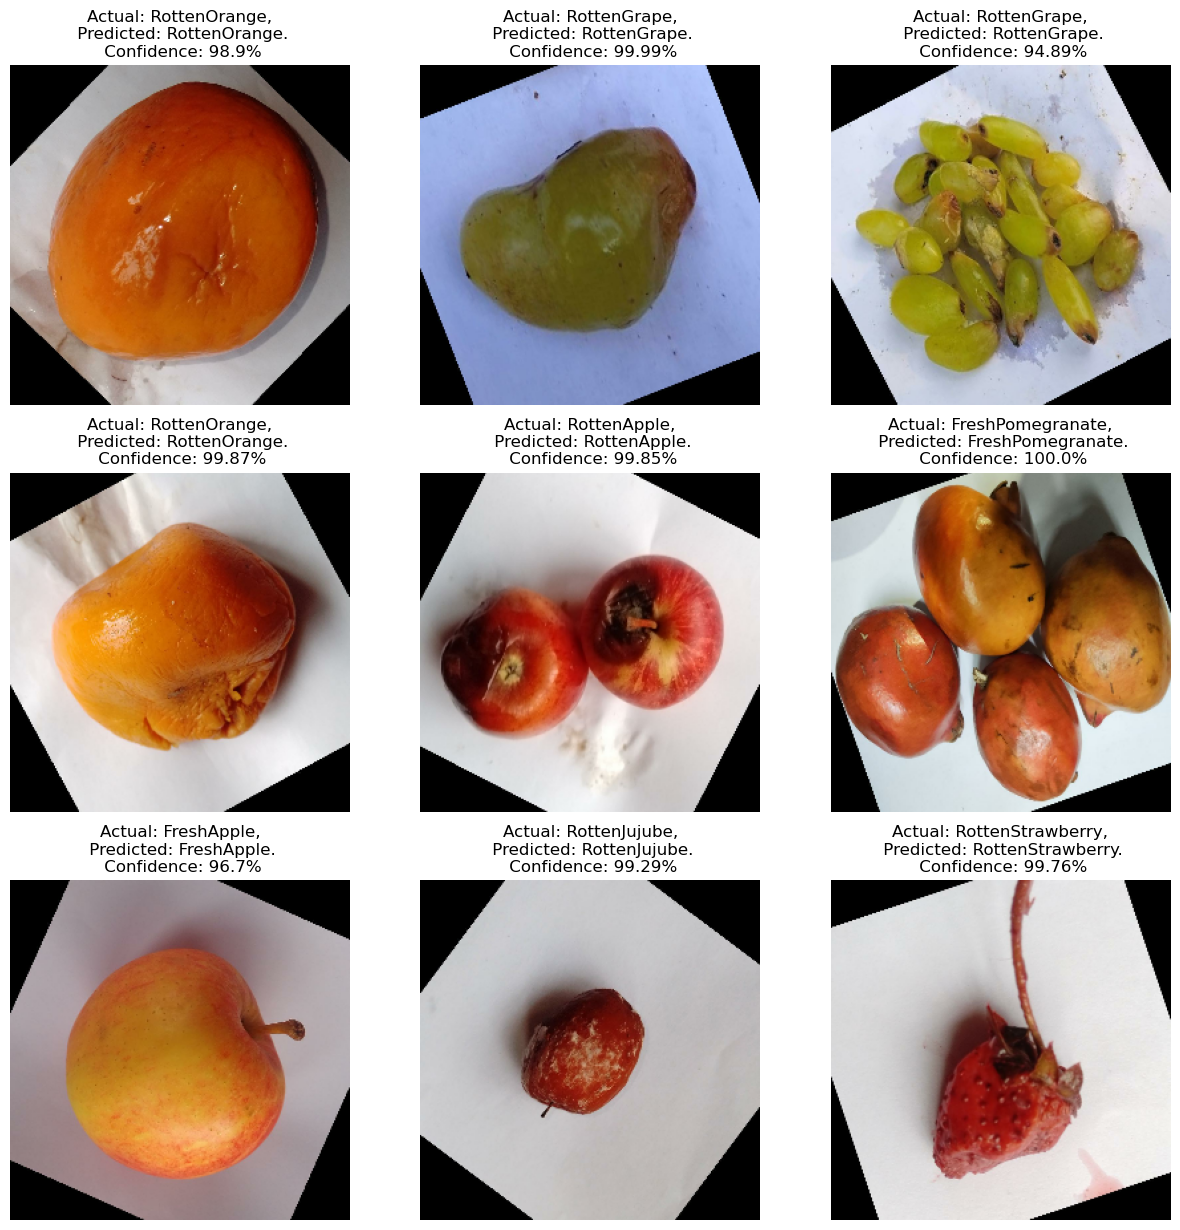

In [41]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [79]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2/assets


INFO:tensorflow:Assets written to: ../models/2/assets


In [45]:
model.save("../fruits.h5")

/Users/macbookpro/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [46]:
converter = tf.lite.TFLiteConverter.from_saved_model("../models/1")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

2023-10-09 01:22:12.541736: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-09 01:22:12.541748: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-09 01:22:12.543187: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ../models/1
2023-10-09 01:22:12.544372: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-09 01:22:12.544376: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: ../models/1
2023-10-09 01:22:12.547688: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-10-09 01:22:12.548587: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-10-09 01:22:12.590495: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: ../models/1
2023-10-09 01:22:12.60

In [47]:
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [48]:
input_details

[{'name': 'serving_default_sequential_input:0',
  'index': 0,
  'shape': array([  1, 256, 256,   3], dtype=int32),
  'shape_signature': array([ -1, 256, 256,   3], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [49]:
output_details

[{'name': 'StatefulPartitionedCall:0',
  'index': 35,
  'shape': array([ 1, 16], dtype=int32),
  'shape_signature': array([-1, 16], dtype=int32),
  'dtype': numpy.float32,
  'quantization': (0.0, 0),
  'quantization_parameters': {'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [50]:
test_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [51]:
test_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [53]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

In [54]:
count = 0
for image, label in test_ds.take(5):
    print(label)
    
print(count)

tf.Tensor(
[ 8 14 12 12  8 11  9 13 14  1 10 14 12 14 10 11  2 10  1  2  0 14  6  2
 12  0  4  6 11 12  0 11], shape=(32,), dtype=int32)
tf.Tensor(
[ 8  5 14  1 12 11  9 11  5  1 14 13  1 13  5 14 14 10  8  6  9  0  4  8
  5  4 11 11  2  2  8  7], shape=(32,), dtype=int32)
tf.Tensor(
[14  9  8  5 12  9  5 12  7  3  2 11 12 12 14  5  8  0  4 11 11  9 12 10
  9  1  1 11  0  8  6  0], shape=(32,), dtype=int32)
tf.Tensor(
[ 9  6  7  7  1 12  2  1  8  4 12 11  4  7 11 13 10 12 11 11 14 14 15  0
 13  4  9 14  8  4 11 12], shape=(32,), dtype=int32)
tf.Tensor(
[ 3  7  9  2 10  4  6  2  6  0  4 14 13  6 13 13  3  2 12  0  3 13 12  7
 12 15 13  4  9 14  4  3], shape=(32,), dtype=int32)
0


In [55]:
for image, label in test_ds.unbatch().take(5):
    print("image shape",image.shape)
    print("label",label)

image shape (256, 256, 3)
label tf.Tensor(8, shape=(), dtype=int32)
image shape (256, 256, 3)
label tf.Tensor(15, shape=(), dtype=int32)
image shape (256, 256, 3)
label tf.Tensor(2, shape=(), dtype=int32)
image shape (256, 256, 3)
label tf.Tensor(4, shape=(), dtype=int32)
image shape (256, 256, 3)
label tf.Tensor(1, shape=(), dtype=int32)


In [56]:
for image, label in test_ds.unbatch().take(5):
    interpreter.set_tensor(input_index, [image.numpy().astype(np.float32)])
    interpreter.invoke()

    output = interpreter.get_tensor(output_index)

In [57]:
predicted_labels = []
actual_labels = []

for image, label in test_ds.unbatch():
    interpreter.set_tensor(input_index, [image])
    interpreter.invoke()

    output = interpreter.get_tensor(output_index)
    predicted_labels.append(np.argmax(output[0]))
    actual_labels.append(label.numpy())

In [58]:
predicted_labels[:10]

[9, 6, 7, 7, 1, 12, 2, 11, 8, 4]

In [59]:
actual_labels[:10]

[9, 6, 7, 7, 1, 12, 2, 1, 8, 4]

In [60]:
comparison_vector = np.array(predicted_labels) == np.array(actual_labels)
comparison_vector[:10]

array([ True,  True,  True,  True,  True,  True,  True, False,  True,
        True])

In [61]:
np.array([True,False,True]).mean()

0.6666666666666666

In [69]:
accuracy = comparison_vector.mean()
accuracy

0.97890625

In [70]:
converter = tf.lite.TFLiteConverter.from_saved_model("../models/1")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

2023-10-09 01:34:39.863451: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2023-10-09 01:34:39.863463: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2023-10-09 01:34:39.863587: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: ../models/1
2023-10-09 01:34:39.864688: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2023-10-09 01:34:39.864693: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: ../models/1
2023-10-09 01:34:39.867324: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2023-10-09 01:34:39.907562: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: ../models/1
2023-10-09 01:34:39.918667: I tensorflow/cc/saved_model/loader.cc:316] SavedModel load for tags { serve }; Status: success: OK. Took 55078 microseconds.


In [71]:
def evaluate_tflite_model(dataset, interpreter):
    input_index = interpreter.get_input_details()[0]["index"]
    output_index = interpreter.get_output_details()[0]["index"]

    prediction_digits = []
    test_labels = []
    for image, label in dataset.unbatch().take(dataset.unbatch().cardinality()):

        test_image = np.expand_dims(image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])
        prediction_digits.append(digit)
        test_labels.append(label)

    prediction_digits = np.array(prediction_digits)
    accuracy = (prediction_digits == test_labels).mean()
    return accuracy

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

test_accuracy = evaluate_tflite_model(dataset, interpreter)

print('TFLite test_accuracy:', test_accuracy)

TFLite test_accuracy: 0.9751114714227807


In [77]:
import os
model_version = max([int(i.split(".")[0]) for i in (os.listdir("../tf-lite-models")+["0.tflite"])]) + 1

with open(
    f"../tf-lite-models/{model_version}.tflite",
    'wb'
) as f:
    f.write(tflite_model)

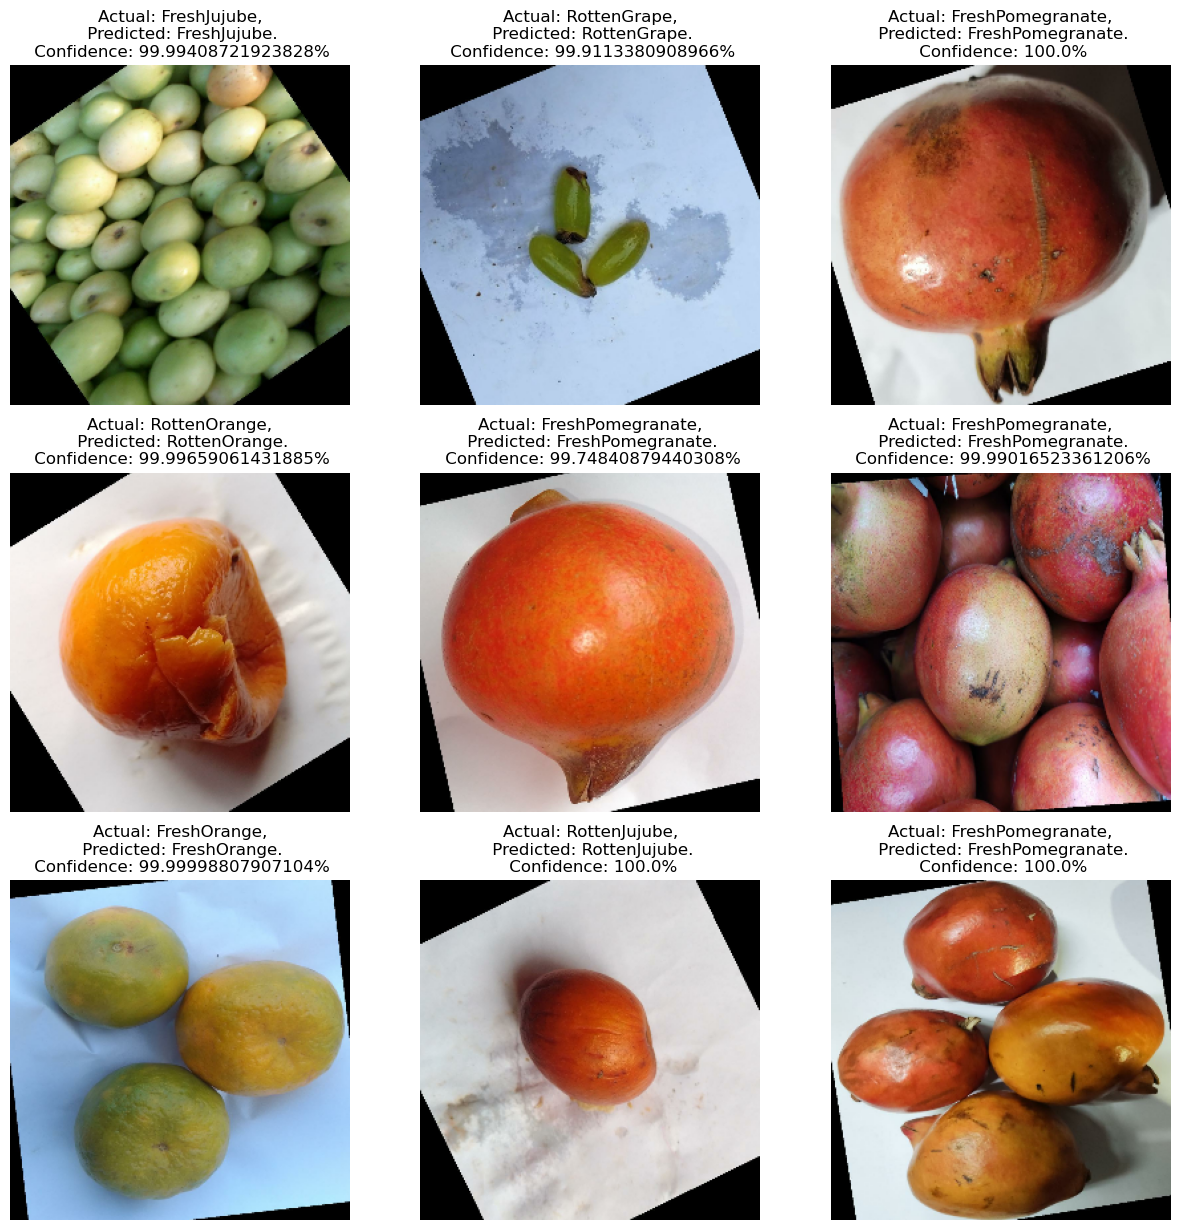

In [78]:
input_index = interpreter.get_input_details()[0]["index"]
output_index = interpreter.get_output_details()[0]["index"]

plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))        

        actual_class = class_names[labels[i]]

        test_image = np.expand_dims(images[i], axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        output = interpreter.tensor(output_index)
        digit = np.argmax(output()[0])

        predicted_class = class_names[digit]
        confidence = np.max(output()[0])*100

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")

In [80]:
model.save("../tflit_fruits.h5")

/Users/macbookpro/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
